In [2]:
import pandas as pd, numpy as np
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

path = r"master_dataset.csv"
df = pd.read_csv(path, low_memory=False)
print("Loaded:", df.shape)


Loaded: (92671, 63)


In [2]:
import pandas as pd, numpy as np
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("master_dataset_fe_v1_encoded.csv.gz")
df.shape


(92671, 83)

In [12]:
df.columns.tolist()

['player_id',
 'player_name',
 'date_of_birth',
 'country_of_birth',
 'height',
 'citizenship',
 'is_eu',
 'position',
 'main_position',
 'foot',
 'current_club_id',
 'current_club_name',
 'joined',
 'contract_expires',
 'player_agent_id',
 'social_media_url_has_url',
 'second_club_url_has_url',
 'third_club_url_has_url',
 'fourth_club_url_has_url',
 'team_id',
 'inj_total_injuries',
 'inj_total_days_out',
 'inj_mean_days_out',
 'inj_seasons_with_injury',
 'perf_minutes_played',
 'perf_goals',
 'perf_assists',
 'perf_clean_sheets',
 'perf_goals_conceded',
 'perf_goals_per90',
 'perf_assists_per90',
 'nat_matches',
 'nat_goals',
 'pv_mv_max',
 'pv_mv_min',
 'pv_mv_mean',
 'pv_mv_std',
 'pv_mv_count',
 'pv_mv_growth',
 'pv_mv_current',
 'tr_num_transfers',
 'tr_total_transfer_fees',
 'tr_last_transfer_fee',
 'tr_first_transfer_date',
 'tr_last_transfer_date',
 'tr_years_since_last_transfer',
 'tm_unique_teammates',
 'tm_joint_minutes',
 'tm_joint_goal_participation',
 'team_club_name',
 

In [ ]:

candidate_targets = ['pv_mv_current','pv_mv_mean','pv_mv_max','pv_mv_min','pv_mv_mean']
target_col = next((c for c in candidate_targets if c in df.columns), None)
if target_col is None:
    print("Warning: No pv_mv_* target column found. No price imputation will be performed.")
else:
    print("Selected market-value target:", target_col)


player_col = 'player_name' if 'player_name' in df.columns else next((c for c in df.columns if 'player' in c.lower()), None)
date_candidates = ['tr_first_transfer_date','tr_last_transfer_date','joined','contract_expires','date_of_birth']
date_col = next((c for c in date_candidates if c in df.columns), None)
print("Using player key:", player_col, "Using date column:", date_col)


Loaded master dataset shape: (92671, 63)
Selected market-value target: pv_mv_current
Using player key: player_name Using date column: tr_first_transfer_date


In [ ]:

date_cols_present = [c for c in date_candidates if c in df.columns]
for c in date_cols_present:
    df[c] = pd.to_datetime(df[c], errors='coerce', dayfirst=True)

for c in date_cols_present:
    df[c + "_year"] = df[c].dt.year
    df[c + "_month"] = df[c].dt.month
    df[c + "_day"] = df[c].dt.day

print("Converted date columns and created parts for:", date_cols_present)


Converted date columns and created parts for: ['tr_first_transfer_date', 'tr_last_transfer_date', 'joined', 'contract_expires', 'date_of_birth']


In [ ]:

important_cols = []
if target_col: important_cols.append(target_col)
for c in ['perf_minutes_played','perf_goals','perf_assists','pv_mv_count','tr_last_transfer_fee','sentiment_score_norm','tweet_count']:
    if c in df.columns: important_cols.append(c)

for c in important_cols:
    flag = c + "_missing_flag"
    if flag not in df.columns:
        df[flag] = df[c].isna().astype(int)

print("Missingness flags created for:", important_cols)


Missingness flags created for: ['pv_mv_current', 'perf_minutes_played', 'perf_goals', 'perf_assists', 'pv_mv_count', 'tr_last_transfer_fee', 'sentiment_score_norm', 'tweet_count']


In [ ]:
if player_col is not None and date_col is not None and target_col is not None:
    df = df.sort_values([player_col, date_col]).reset_index(drop=True)
    before_na = df[target_col].isna().sum()
    df[target_col] = df.groupby(player_col)[target_col].ffill()
    df[target_col] = df.groupby(player_col)[target_col].bfill()
    after_na = df[target_col].isna().sum()
    print(f"Per-player ffill/bfill applied to {target_col}: missing before {before_na}, after {after_na}")
    perf_cols = [c for c in ['perf_minutes_played','perf_goals','perf_assists','pv_mv_count'] if c in df.columns]
    for c in perf_cols:
        df[c] = df.groupby(player_col)[c].ffill()
        df[c] = df.groupby(player_col)[c].bfill()
    print("Applied per-player ffill/bfill to perf cols:", perf_cols)
else:
    print("Skipping per-player forward/backfill (missing player/date/target).")


Per-player ffill/bfill applied to pv_mv_current: missing before 23230, after 23601
Applied per-player ffill/bfill to perf cols: ['perf_minutes_played', 'perf_goals', 'perf_assists', 'pv_mv_count']


In [ ]:
# choose group key preference: position -> main_position -> current_club_name -> team_club_name
group_keys = [k for k in ['position','main_position','current_club_name','team_club_name'] if k in df.columns]
group_key = group_keys[0] if group_keys else None
print("Group key for median fallback:", group_key)

# numeric columns list (exclude id-like and boolean)
exclude_cols = [player_col, 'player_id'] if player_col else ['player_id']
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns.tolist() if c not in exclude_cols]

# For target: fill using group median then global median
if target_col:
    if group_key:
        med_by_group = df.groupby(group_key)[target_col].median()
        # apply group median where target is null
        def fill_target_grp(row):
            if pd.isna(row[target_col]):
                g = row.get(group_key)
                if pd.notna(g) and g in med_by_group.index and not pd.isna(med_by_group.loc[g]):
                    return med_by_group.loc[g]
            return row[target_col]
        df[target_col] = df.apply(fill_target_grp, axis=1)
    df[target_col].fillna(df[target_col].median(), inplace=True)
    print("After group/global fill, remaining missing for target:", df[target_col].isna().sum())

for c in num_cols:
    if df[c].isna().sum() == 0:
        continue
    if group_key:
        medg = df.groupby(group_key)[c].median()
        df[c] = df.apply(lambda row: medg.loc[row[group_key]] if pd.isna(row[c]) and pd.notna(row.get(group_key)) and row[group_key] in medg.index and not pd.isna(medg.loc[row[group_key]]) else row[c], axis=1)
    # fallback global median
    df[c].fillna(df[c].median(), inplace=True)

print("Completed group-wise then global-median fallback for numeric columns.")


Group key for median fallback: position
After group/global fill, remaining missing for target: 0
Completed group-wise then global-median fallback for numeric columns.


In [ ]:
from sklearn.impute import IterativeImputer
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns.tolist() if c not in exclude_cols]

# identify columns still with missing values
to_impute = [c for c in num_cols if df[c].isna().sum() > 0]
print("Numeric columns still with missing values (to impute):", to_impute)

if len(to_impute) > 0:
    # prepare imputer input (use a subset of numeric features to avoid noisy cols)
    imputer = IterativeImputer(random_state=42, max_iter=10)
    impute_df = df[to_impute].copy()
    # fit_transform
    imputed_values = imputer.fit_transform(impute_df)
    imputed_df = pd.DataFrame(imputed_values, columns=to_impute, index=df.index)
    for c in to_impute:
        df[c] = imputed_df[c]
    print("IterativeImputer applied to remaining numeric missing values.")
else:
    print("No numeric columns require IterativeImputer.")


Numeric columns still with missing values (to impute): []
No numeric columns require IterativeImputer.


In [8]:
cat_cols = [c for c in df.select_dtypes(include=['object','category']).columns if c not in exclude_cols]
print("Categorical columns count:", len(cat_cols))

for col in cat_cols:
    if df[col].isna().sum() == 0:
        continue
    # try group-mode if group_key exists and not same as col
    if group_key and col != group_key:
        df[col] = df.groupby(group_key)[col].transform(lambda s: s.fillna(s.mode().iloc[0] if not s.mode().empty else np.nan))
    # global mode fallback
    if df[col].isna().sum() > 0:
        mode_val = df[col].mode().iloc[0] if not df[col].mode().empty else 'unknown'
        df[col].fillna(mode_val, inplace=True)
    # as last resort set 'unknown'
    df[col].fillna('unknown', inplace=True)

print("Categorical imputation complete.")


Categorical columns count: 10
Categorical imputation complete.


In [9]:
# show remaining missing values (should be zero or very small)
remaining_na = df.isna().sum()
remaining_na = remaining_na[remaining_na>0].sort_values(ascending=False)
print("Columns still with missing values (non-zero):")
print(remaining_na)

# Save imputed dataset
out = r"E:\price prediction\master_dataset_imputed_v1.csv.gz"
df.to_csv(out, index=False, compression='gzip')
print("Saved imputed dataset to:", out)


Columns still with missing values (non-zero):
contract_expires          54005
joined                    25317
tr_first_transfer_date     2218
tr_last_transfer_date      2218
date_of_birth              1006
player_name                 520
dtype: int64
Saved imputed dataset to: E:\price prediction\master_dataset_imputed_v1.csv.gz


In [11]:
date_cols_to_null = [
    'contract_expires',
    'joined',
    'tr_first_transfer_date',
    'tr_last_transfer_date',
    'date_of_birth'
]

# Convert to datetime first (important)
for col in date_cols_to_null:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Set missing values to NaT (null datetime)
for col in date_cols_to_null:
    df[col] = df[col].fillna(pd.NaT)

# Handle player_name (string column)
df['player_name'] = df['player_name'].fillna("unknown")

print("Missing date columns set to NaT and player_name set to 'unknown'.")
# Save imputed dataset
out = r"E:\price prediction\master_dataset_imputed_v1.csv.gz"
df.to_csv(out, index=False, compression='gzip')
print("Saved imputed dataset to:", out)


Missing date columns set to NaT and player_name set to 'unknown'.
Saved imputed dataset to: E:\price prediction\master_dataset_imputed_v1.csv.gz


In [8]:
duplicate_count = df.duplicated().sum()
duplicate_count


np.int64(0)

In [10]:
missing_summary = pd.DataFrame({
    "Missing_Count": df.isnull().sum(),
    "Missing_Percentage": (df.isnull().mean() * 100).round(2)
})

missing_summary


,Missing_Count,Missing_Percentage
player_id,0,0.00
player_name,520,0.56
date_of_birth,1006,1.09
country_of_birth,16645,17.96
height,4,0.00
...,...,...
sentiment_score_norm,67506,72.84
tweet_count,67506,72.84
positive_ratio,67506,72.84
negative_ratio,67506,72.84


In [11]:
missing_summary[missing_summary["Missing_Count"] > 0]


,Missing_Count,Missing_Percentage
player_name,520,0.56
date_of_birth,1006,1.09
country_of_birth,16645,17.96
height,4,0.00
citizenship,57,0.06
position,2,0.00
main_position,2,0.00
foot,23488,25.35
joined,25317,27.32
contract_expires,54005,58.28


In [12]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

date_cols = [
    "date_of_birth","joined","contract_expires",
    "tr_first_transfer_date","tr_last_transfer_date"
]

sentiment_cols = [
    "sentiment_score_norm","tweet_count",
    "positive_ratio","negative_ratio","sentiment_volatility"
]

per90_cols = [
    "perf_goals_per90","perf_assists_per90",
    "goals_per90","assists_per90"
]

transfer_fee_cols = ["tr_total_transfer_fees","tr_last_transfer_fee"]


In [13]:
# 1. Numeric columns -> Fill 0
df[num_cols] = df[num_cols].fillna(0)

# 2. Categorical columns -> Fill "Unknown"
df[cat_cols] = df[cat_cols].fillna("Unknown")

# 3. Date columns -> Fill NaN 
df[date_cols] = df[date_cols].fillna(np.nan)

# 4. Per 90 metrics -> 0
df[per90_cols] = df[per90_cols].fillna(0)

# 5. Sentiment columns -> 0
df[sentiment_cols] = df[sentiment_cols].fillna(0)

# 6. Transfer fee columns -> 0
df[transfer_fee_cols] = df[transfer_fee_cols].fillna(0)


In [14]:
df.isnull().sum()

player_id               0
player_name             0
date_of_birth           0
country_of_birth        0
height                  0
                       ..
sentiment_score_norm    0
tweet_count             0
positive_ratio          0
negative_ratio          0
sentiment_volatility    0
Length: 63, dtype: int64

In [15]:
df.to_csv("master_dataset_imputed_v1.csv.gz", index=False, compression="gzip")


<Figure size 1500x1000 with 0 Axes>

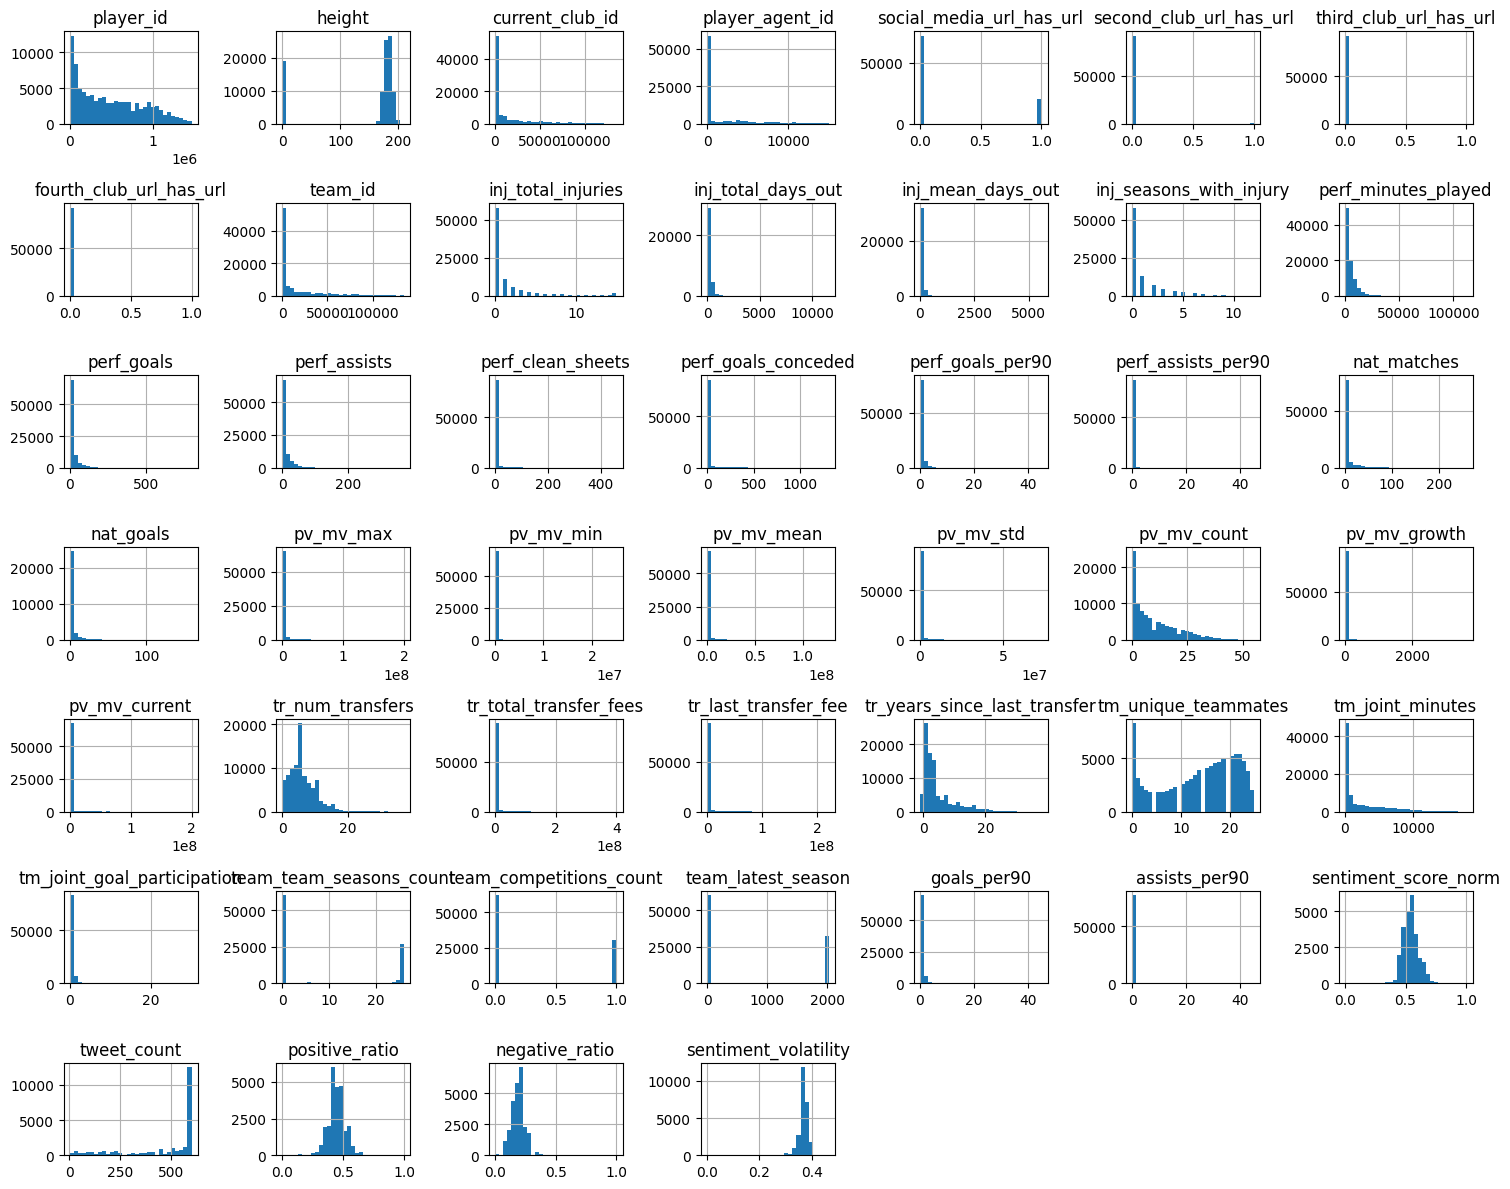

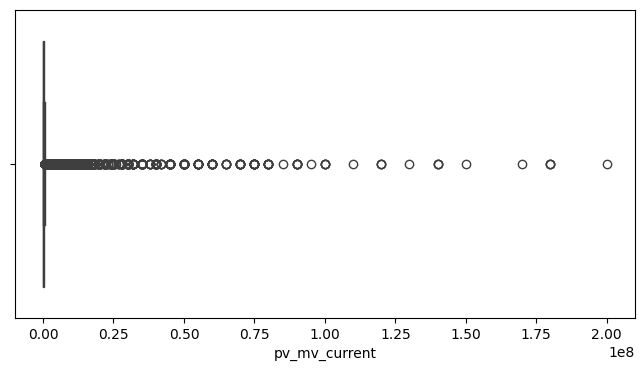

In [4]:


num_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15, 10))
df[num_cols].hist(bins=30, figsize=(15, 12))
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x=df['pv_mv_current'])
plt.show()


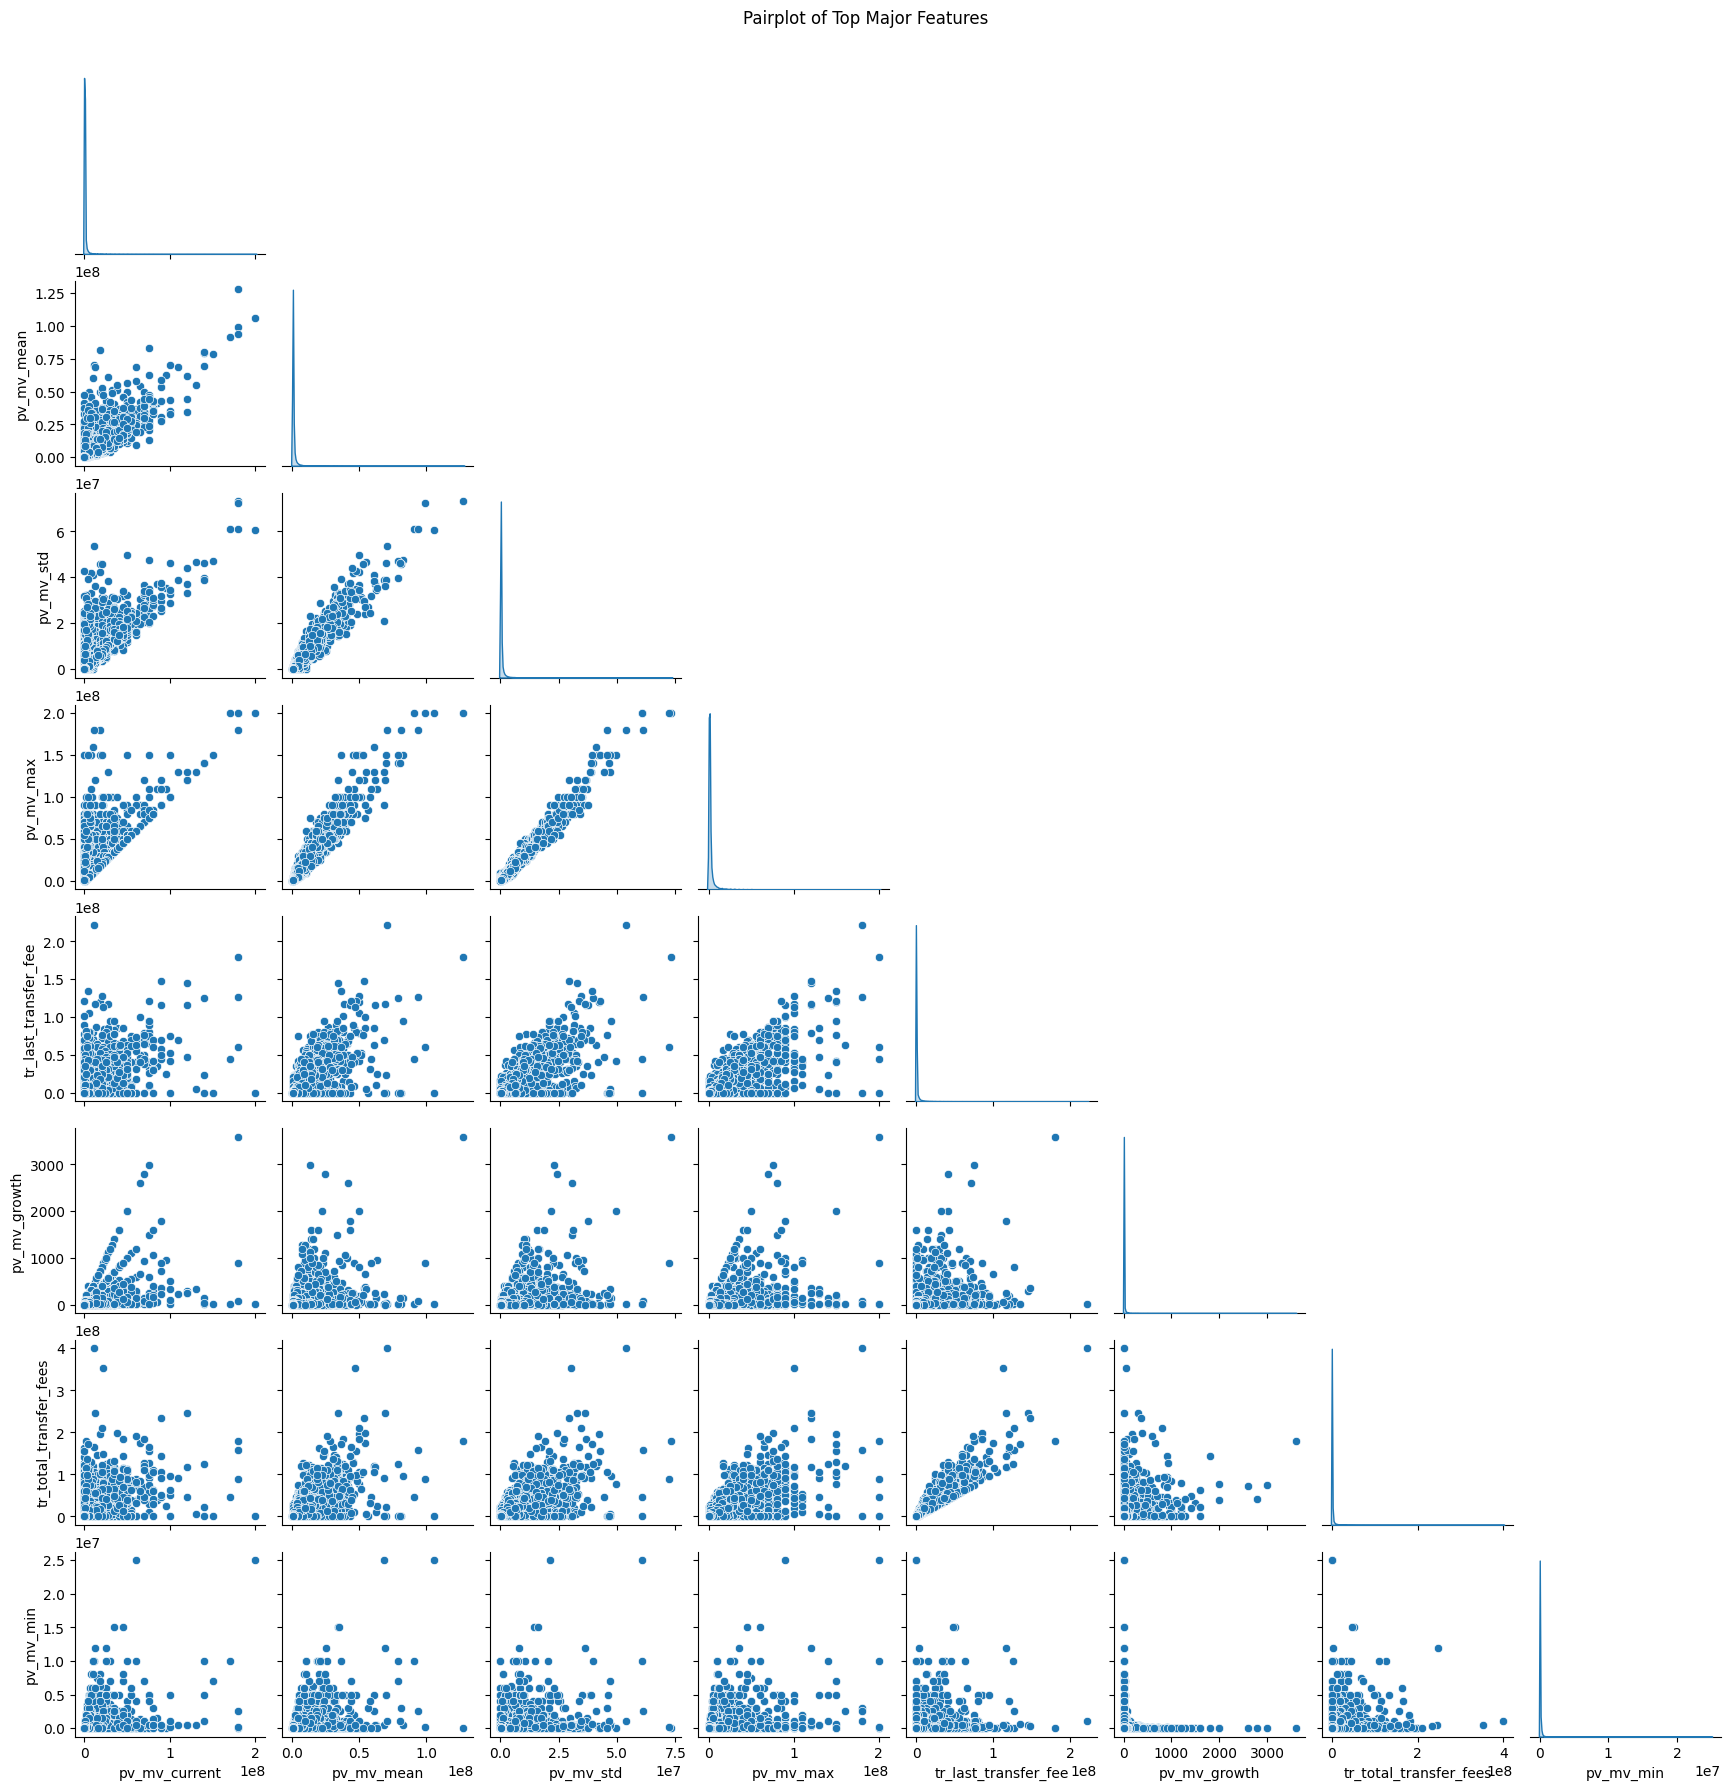

In [ ]:
target_col = "pv_mv_current"

num_cols = df.select_dtypes(include=['int64','float64']).columns
corrs = df[num_cols].corrwith(df[target_col]).abs().sort_values(ascending=False)
top_features = corrs.head(8).index.tolist()
top_features

sns.pairplot(df[top_features], diag_kind="kde", corner=True, height=2.2)
plt.suptitle("Pairplot of Top Major Features", y=1.02)
plt.show()




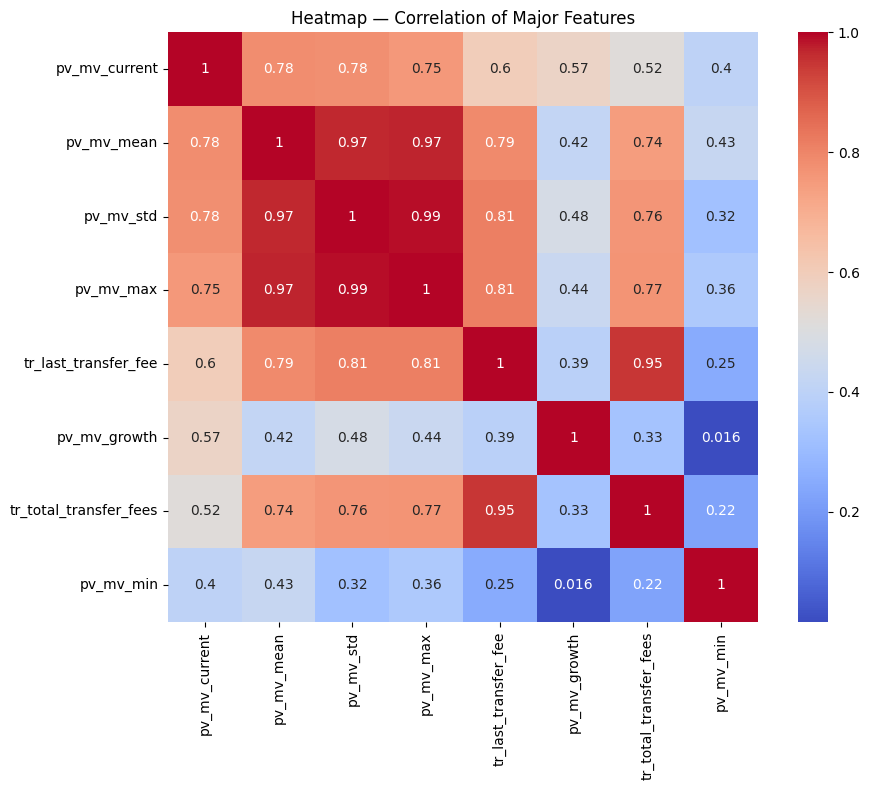

In [7]:
plt.figure(figsize=(10,8))
sns.heatmap(df[top_features].corr(), annot=True, cmap="coolwarm", square=True)
plt.title("Heatmap — Correlation of Major Features")
plt.tight_layout()
plt.show()


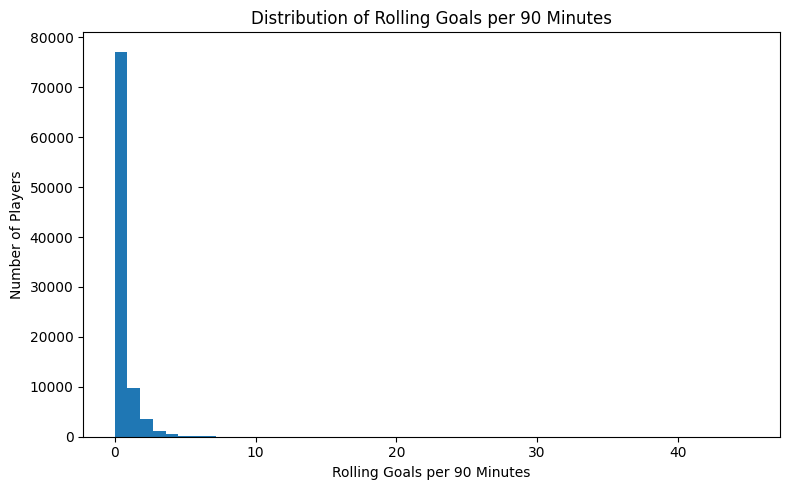

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("merged_ml.csv.gz")

data = df[["main_position", "perf_goals_rolling_5"]].dropna()

plt.figure(figsize=(9,5))
data.boxplot(column="perf_goals_rolling_5", by="main_position", rot=45)
plt.xlabel("Position")
plt.ylabel("Rolling Goals per 90")
plt.title("Rolling Goals per 90 Minutes by Position")
plt.suptitle("")
plt.tight_layout()
plt.show()


## Outlier Analysis

In [ ]:

numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()

def iqr_outlier_summary(df, cols):
    rows = []
    n = len(df)
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_mask = (df[col] < lower) | (df[col] > upper)
        outlier_count = outlier_mask.sum()
        outlier_pct = (outlier_count / n) * 100
        rows.append({
            "feature": col,
            "Q1": Q1, "Q3": Q3, "IQR": IQR,
            "lower": lower, "upper": upper,
            "outlier_count": int(outlier_count),
            "outlier_pct": round(outlier_pct, 2),
            "n_nonnull": int(df[col].notnull().sum())
        })
    return pd.DataFrame(rows).sort_values(by="outlier_pct", ascending=False)

outlier_df = iqr_outlier_summary(df, numeric_cols)
outlier_df.head(50)   


,feature,Q1,Q3,IQR,lower,upper,outlier_count,outlier_pct,n_nonnull
4,social_media_url_has_url,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,20337,21.95,92671
42,tweet_count,0.00000,98.000000,98.000000,-1.470000e+02,2.450000e+02,20192,21.79,92671
30,tr_total_transfer_fees,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,19870,21.44,92671
31,tr_last_transfer_fee,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,19870,21.44,92671
1,height,171.00000,185.000000,14.000000,1.500000e+02,2.060000e+02,18875,20.37,92671
20,nat_matches,0.00000,2.000000,2.000000,-3.000000e+00,5.000000e+00,17902,19.32,92671
27,pv_mv_growth,-1.00000,0.500000,1.500000,-3.250000e+00,2.750000e+00,14785,15.95,92671
10,inj_total_days_out,0.00000,74.000000,74.000000,-1.110000e+02,1.850000e+02,14257,15.38,92671
12,inj_seasons_with_injury,0.00000,1.000000,1.000000,-1.500000e+00,2.500000e+00,14063,15.18,92671
25,pv_mv_std,0.00000,207141.824764,207141.824764,-3.107127e+05,5.178546e+05,12944,13.97,92671


In [ ]:

MIN_OUTLIER_PCT = 1.0   
MIN_OUTLIER_COUNT = 50

candidates = outlier_df[
    (outlier_df['outlier_pct'] >= MIN_OUTLIER_PCT) &
    (outlier_df['outlier_count'] >= MIN_OUTLIER_COUNT)
]['feature'].tolist()

protected = ['market_value']   
to_handle = [c for c in candidates if c not in protected]

print("Protected columns (won't be changed):", protected)
print("Auto-selected features to CAP (sample):", to_handle[:30])


Protected columns (won't be changed): ['market_value']
Auto-selected features to CAP (sample): ['social_media_url_has_url', 'tweet_count', 'tr_total_transfer_fees', 'tr_last_transfer_fee', 'height', 'nat_matches', 'pv_mv_growth', 'inj_total_days_out', 'inj_seasons_with_injury', 'pv_mv_std', 'pv_mv_max', 'pv_mv_current', 'nat_goals', 'pv_mv_mean', 'team_id', 'current_club_id', 'inj_mean_days_out', 'tm_joint_goal_participation', 'perf_goals_conceded', 'perf_assists', 'perf_goals', 'inj_total_injuries', 'perf_clean_sheets', 'perf_goals_per90', 'goals_per90', 'pv_mv_min', 'player_agent_id', 'tr_years_since_last_transfer', 'assists_per90', 'perf_assists_per90']
